In [53]:
#-------------------------------------
# practice 3-1
#-------------------------------------
import os 
import torch
from torch import nn 
from torch.nn import functional as F 
from torch.utils.data import DataLoader, random_split 
from torchvision import transforms
from torchvision.datasets import MNIST 

PATH_DATASETS = ""
BATCH_SIZE = 1024 
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu"
                      )
 # down load the MNIST 
train_ds = MNIST(PATH_DATASETS, train=True, download=True,
                  transform=transforms.ToTensor())

In [54]:
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                transform=transforms.ToTensor())

print(train_ds.data.shape, test_ds.data.shape)
print(train_ds.targets.shape, test_ds.targets.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


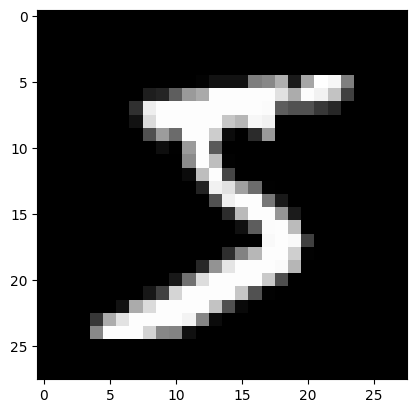

In [55]:
print(train_ds.targets[:10])

import os 
import matplotlib.pyplot as plt 

X = train_ds.data[0]
plt.imshow(X.reshape(28,28), cmap='gray')
plt.show()

In [56]:
# create model 
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 256),
    torch.nn.Linear(256, 10),
).to(device)

epochs = 5 
lr = 0.1

# create dataloader
train_loader = DataLoader(train_ds, batch_size=600)

# set optimizer 
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

model.train()
loss_list=[]

for epoch in range(1, epochs+1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0 :
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f}%)' 
                  + f' Loss: {loss.item():.6f}')






Epoch 1: [    0 / 60000] (0%) Loss: 2.309567
Epoch 1: [ 6000 / 60000] (10%) Loss: 2.015340
Epoch 1: [12000 / 60000] (20%) Loss: 1.790330
Epoch 1: [18000 / 60000] (30%) Loss: 1.554358
Epoch 1: [24000 / 60000] (40%) Loss: 1.326396
Epoch 1: [30000 / 60000] (50%) Loss: 1.221680
Epoch 1: [36000 / 60000] (60%) Loss: 0.989738
Epoch 1: [42000 / 60000] (70%) Loss: 0.957580
Epoch 1: [48000 / 60000] (80%) Loss: 0.704367
Epoch 1: [54000 / 60000] (90%) Loss: 0.726599
Epoch 2: [    0 / 60000] (0%) Loss: 0.684240
Epoch 2: [ 6000 / 60000] (10%) Loss: 0.538975
Epoch 2: [12000 / 60000] (20%) Loss: 0.638990
Epoch 2: [18000 / 60000] (30%) Loss: 0.540132
Epoch 2: [24000 / 60000] (40%) Loss: 0.566175
Epoch 2: [30000 / 60000] (50%) Loss: 0.614809
Epoch 2: [36000 / 60000] (60%) Loss: 0.501089
Epoch 2: [42000 / 60000] (70%) Loss: 0.597797
Epoch 2: [48000 / 60000] (80%) Loss: 0.406213
Epoch 2: [54000 / 60000] (90%) Loss: 0.459593
Epoch 3: [    0 / 60000] (0%) Loss: 0.454184
Epoch 3: [ 6000 / 60000] (10%) Loss: 

Average_loss: 0.0000, correct_rate: 9057/10000 (91%)



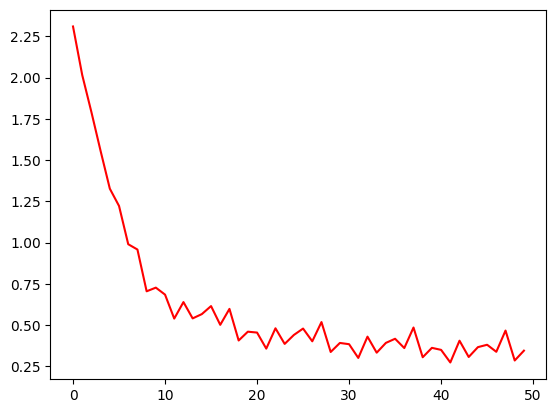

In [57]:
import matplotlib.pyplot as plt
plt.plot(loss_list, 'r')

test_loader = DataLoader(test_ds, shuffle=False, batch_size=test_ds.targets.shape[0])

model.eval()
test_loss = 0
correct = 0
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    # sum up batch loss
    test_loss += criterion(output, target).item()
    pred = output.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'Average_loss: {test_loss:.4f}, correct_rate: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')



In [58]:
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device) # *:Unpack the list into independent parameters
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

import numpy as np

i=8
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device) # *:Unpack the list into independent parameters

#print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9 predict rate: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9 predict rate: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4
0~9 predict rate: [[0.01 0.   0.06 0.   0.03 0.01 0.88 0.   0.01 0.  ]]
0~9 predict rate: [6]


In [59]:
# save and load model 
# save model
torch.save(model, 'model.pt')

# load model
model = torch.load('model.pt')

# save weights
torch.save(model.state_dict(), 'model.pth') 
# model.state_dict(), using dictionary to represent parameters of model
# load weights
model.load_state_dict(torch.load('model.pth'))

# show state_dict of each dimension 
print("The state_dict of each layer:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


The state_dict of each layer:
1.weight 	 torch.Size([256, 784])
1.bias 	 torch.Size([256])
2.weight 	 torch.Size([10, 256])
2.bias 	 torch.Size([10])


In [60]:
!pip install scikit-image

In [80]:
"""from skimage import io
from skimage.transform import resize
import numpy as np

for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # resize to (28, 28) 
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(1,28, 28) 

    # reverse to color (255->0, 0->255
    X1 = torch.FloatTensor(1.0-X1).to(device)

    # predict
    predictions = torch.softmax(model(X1), dim=1)
    print(f'actual/prediction: {i}{np.argmax(predictions.detach().cpu().numpy())}')"""

"from skimage import io\nfrom skimage.transform import resize\nimport numpy as np\n\nfor i in range(10):\n    uploaded_file = f'./myDigits/{i}.png'\n    image1 = io.imread(uploaded_file, as_gray=True)\n\n    # resize to (28, 28) \n    image_resized = resize(image1, (28, 28), anti_aliasing=True)    \n    X1 = image_resized.reshape(1,28, 28) \n\n    # reverse to color (255->0, 0->255\n    X1 = torch.FloatTensor(1.0-X1).to(device)\n\n    # predict\n    predictions = torch.softmax(model(X1), dim=1)\n    print(f'actual/prediction: {i}{np.argmax(predictions.detach().cpu().numpy())}')"

In [29]:
!pip install torchinfo

In [30]:
print(model)

# Show summary of model
for name, module in model.named_children():
    print(f'{name}: {module}')

from torchinfo import summary
print(summary(model, (60000, 28, 28))) # input dimension

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Linear(in_features=256, out_features=10, bias=True)
)
0: Flatten(start_dim=1, end_dim=-1)
1: Linear(in_features=784, out_features=256, bias=True)
2: Linear(in_features=256, out_features=10, bias=True)
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [60000, 10]               --
├─Flatten: 1-1                           [60000, 784]              --
├─Linear: 1-2                            [60000, 256]              200,960
├─Linear: 1-3                            [60000, 10]               2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
Total mult-adds (G): 12.21
Input size (MB): 188.16
Forward/backward pass size (MB): 127.68
Params size (MB): 0.81
Estimated Total Size (MB): 316.65


In [ ]:
"""from skimage import io
from skimage.transform import resize
import numpy as np

for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # resize to (28, 28) 
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(1,28, 28) 

    # reverse to color (255->0, 0->255
    X1 = torch.FloatTensor(1.0-X1).to(device)

    # predict
    predictions = torch.softmax(model(X1), dim=1)
    print(f'actual/prediction: {i}{np.argmax(predictions.detach().cpu().numpy())}')"""

In [87]:
#--------------------------
# predict the even or odd 
#--------------------------
# define even_func 
def even_odd(num):
    return "even" if num % 2 == 0 else 'odd'

predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device) # *:Unpack the list into independent parameters
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))
        print(f'actual/prediction/(even/odd): {target} {output.item()} ({even_odd(output.item())})')




actual/prediction/(even/odd): 7 7 (odd)
actual/prediction/(even/odd): 2 2 (even)
actual/prediction/(even/odd): 1 1 (odd)
actual/prediction/(even/odd): 0 0 (even)
actual/prediction/(even/odd): 4 4 (even)
actual/prediction/(even/odd): 1 1 (odd)
actual/prediction/(even/odd): 4 4 (even)
actual/prediction/(even/odd): 9 9 (odd)
actual/prediction/(even/odd): 5 6 (even)
actual/prediction/(even/odd): 9 9 (odd)
actual/prediction/(even/odd): 0 0 (even)
actual/prediction/(even/odd): 6 6 (even)
actual/prediction/(even/odd): 9 9 (odd)
actual/prediction/(even/odd): 0 0 (even)
actual/prediction/(even/odd): 1 1 (odd)
actual/prediction/(even/odd): 5 5 (odd)
actual/prediction/(even/odd): 9 9 (odd)
actual/prediction/(even/odd): 7 7 (odd)
actual/prediction/(even/odd): 3 3 (odd)
actual/prediction/(even/odd): 4 4 (even)


odd
